In [18]:
import hashlib

from sklearn.datasets import load_boston
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression


In [19]:
def boston_as_dataframe():
    bos = load_boston(return_X_y=True)
    data = bos[0]
    target = bos[1]
    df = pd.DataFrame(data=data,
                      columns=["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B 1000", "LSTAT"])
    df["TARGET"] = target
    return df, target

First, Let's look at the data we are working with. The commands below will generate some descriptive statistics for 
each of features, and will show histograms for those features as well.

   index     CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0      0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1      1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2      2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3      3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4      4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO  B 1000  LSTAT  TARGET  
0     15.3  396.90   4.98    24.0  
1     17.8  396.90   9.14    21.6  
2     17.8  392.83   4.03    34.7  
3     18.7  394.63   2.94    33.4  
4     18.7  396.90   5.33    36.2  
            index        CRIM          ZN       INDUS        CHAS         NOX  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean   252.500000    3.613524   11.363636   11.136779    0.069170    0.554695   
std    146.213884    8.601545   23.322453    6.860353    0.2

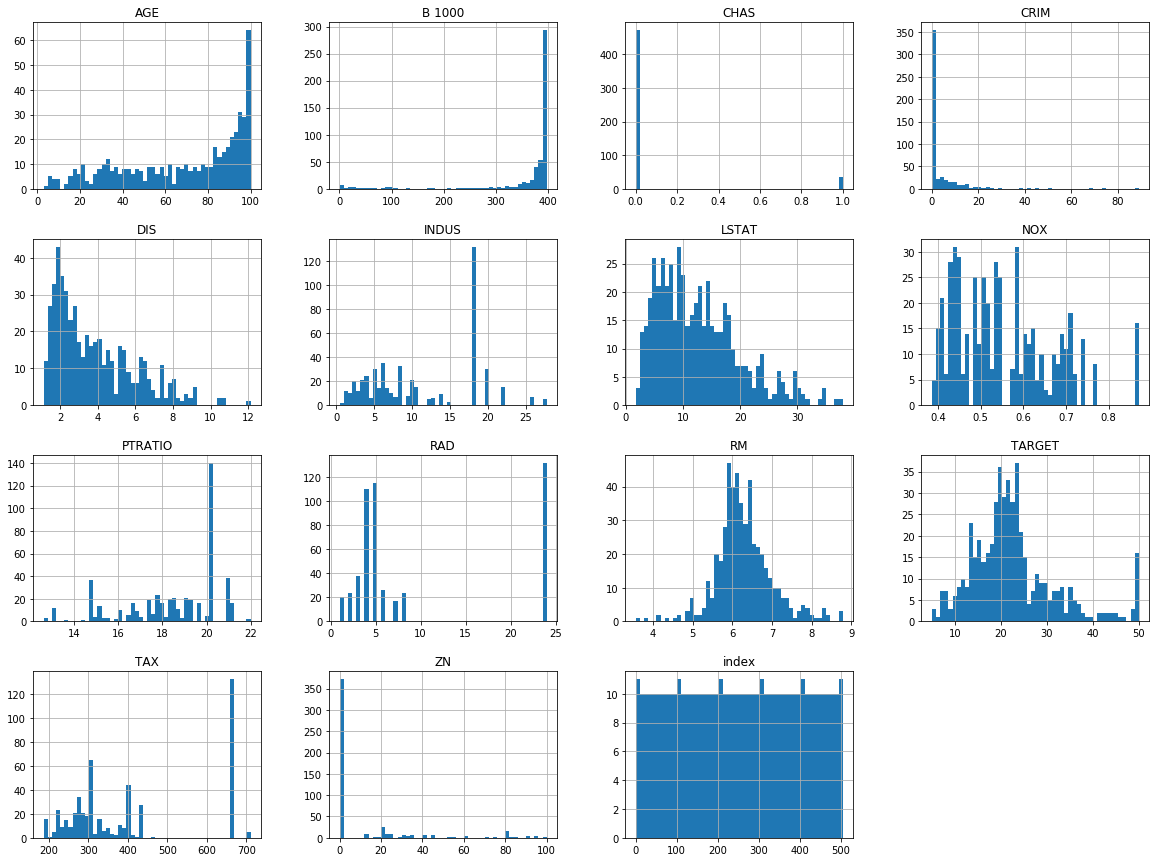

In [20]:
df, target = boston_as_dataframe()
df_with_index = df.reset_index()

print(df_with_index.head(5))
print(df_with_index.describe())
df_with_index.hist(bins=50, figsize=(20, 15))
plt.show()

Some of the features seem to have strong tail activity- either outliers at the tails or the distribution seems a little skewed.
I am not sure exactly how to handle these potential data disturbances, and the book makes a note about cleaning these issues up.


In [21]:
# Create a hash on the index for the test set in order to reproducibly create the test set.

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test(data, test_ratio, id_col, hash=hashlib.md5):
    ids = data[id_col]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    
    # shuffled_indices = np.random.permutation(len(data))
    # test_set_size = int(len(data) * test_ratio)
    # test_indices = shuffled_indices[:test_set_size]
    # train_indices = shuffled_indices[test_set_size:]
    return data.loc[~in_test_set], data.loc[in_test_set]

train, test = split_train_test(df_with_index, 0.2, "index")
print(train)
print()
print(test)


     index     CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  \
0        0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0   
1        1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0   
2        2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0   
3        3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0   
6        6  0.08829  12.5   7.87   0.0  0.524  6.012  66.6  5.5605  5.0   
..     ...      ...   ...    ...   ...    ...    ...   ...     ...  ...   
501    501  0.06263   0.0  11.93   0.0  0.573  6.593  69.1  2.4786  1.0   
502    502  0.04527   0.0  11.93   0.0  0.573  6.120  76.7  2.2875  1.0   
503    503  0.06076   0.0  11.93   0.0  0.573  6.976  91.0  2.1675  1.0   
504    504  0.10959   0.0  11.93   0.0  0.573  6.794  89.3  2.3889  1.0   
505    505  0.04741   0.0  11.93   0.0  0.573  6.030  80.8  2.5050  1.0   

       TAX  PTRATIO  B 1000  LSTAT  TARGET  
0    296.0     15.3  396.90   4.98    24.0  
1    242.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea4d677ed0>,
      dtype=object)

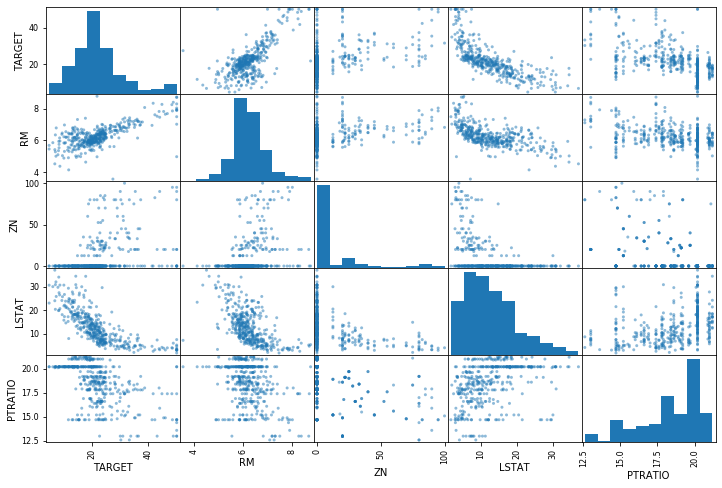

In [22]:
## Discovery and Visualization
housing = train.copy()
corr_matrix = housing.corr()
corr_matrix["TARGET"].sort_values(ascending=False)

attributes = ["TARGET", "RM", "ZN", "LSTAT", "PTRATIO"]
scatter_matrix(housing[attributes], figsize=(12, 8))


In [23]:
housing = train.drop("TARGET", axis=1)
housing_labels = train["TARGET"].copy()

h1 = housing[housing.isna().any(axis=1)]
h1

,index,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B 1000,LSTAT


There are no categorical values in the dataset. The next step is to transform the data using a minmax scalar. This results in scaled features. 
The targets do no need to be scaled, but any future features that we make predictions on will need to be scaled.


In [24]:
trans_pipeline = Pipeline([('min_max_scale', MinMaxScaler())])
housing_tr = trans_pipeline.fit_transform(housing)


In [25]:
lin_reg = LinearRegression()
lin_reg.fit(housing_tr, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
some_data = housing.iloc[:5]
some_labels = housing_labels[:5]
some_preped_data = trans_pipeline.fit_transform(some_data)
print(f"Predictions: {lin_reg.predict(some_preped_data)}")
print(f"Labels: {list(some_labels)}")

Predictions: [ 26.88449528   9.23566034  28.69149447  21.38386965 -12.86168757]
Labels: [24.0, 21.6, 34.7, 33.4, 22.9]


It is difficult to tell how well the model performed so we will look into a few model evaluation methods.

In [27]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_tr)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

4.315213971873178

Now we some metric by which to evaluate our model, the mean error (4.31). We can consider the mean value of our target data and maybe even have some idea of the significance of the
range compared to the mean value (22.53). The mean error is about 20% of the mean. This seems like a decent start- potentially about 80% accuracy. 

In [28]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_tr, housing_labels)

housing_predictions = tree_reg.predict(housing_tr)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

The decision tree presents a new problem, the model is learning the data exactly. This means that there is no way of telling if our model will generalize well beyond this test set.
Thus, we will use cross validation to split our test set into 10 groups- 9 of which will be used for training and 1 will best usedkind of as a test set but it is called a validation set.


In [29]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg, housing_tr, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

lin_scores = cross_val_score(lin_reg, housing_tr, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("STDEV: ", scores.std())

print("Tree Regressor:")
display_scores(tree_rmse_scores)
print()
print("Linear Regression: ")
display_scores(lin_rmse_scores)
print()

Tree Regressor:
Scores:  [3.94826297 3.35813537 4.0530025  4.91366934 4.4511166  6.69592158
 4.16225783 9.5175704  4.88157312 5.88184474]
Mean:  5.1863354455738735
STDEV:  1.7157584576531864

Linear Regression: 
Scores:  [ 2.67594623  3.91890976  3.38896583  5.69798835  5.00492781  4.89744902
  2.90525444 10.51542237  5.73138527  3.81666071]
Mean:  4.855290977868559
STDEV:  2.149343945736466



With cross validation, we can better compare the two models we have created. It appears the linear regressor slightly out performed the tree regressor based on the mean.
Next, we will add an ensemble method, which generates several internal models and chooses the best one. In this case, we are using random forest, which uses an ensemble of decision trees.


In [30]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg = forest_reg.fit(housing_tr, housing_labels)

forest_scores = cross_val_score(forest_reg, housing_tr, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

print("Forest Regressor:")
display_scores(forest_rmse_scores)
print()

Forest Regressor:
Scores:  [3.36516156 2.41814035 2.35675394 4.81708814 3.35341502 6.38870865
 3.02505551 7.67877966 4.16685407 4.13644472]
Mean:  4.170640162474259
STDEV:  1.632066325629643



Based on the mean error of the cross validation of the three models we have analyzed thus far, the random forest model has perfomed the best. We will next save this model and the perform a hyper parameter evaluation of this model.


In [31]:
import os
from sklearn.externals import joblib

def save_models(models):
    for model, name in models:
        joblib.dump(model, os.path.join(name))

def load_models(names):
    models = []
    for name in names:
        m = joblib.load(name)
        models.append((m, name))
    return models
        
models = [(tree_reg, "tree_regressor.pkl"),
          (lin_reg, "linear_regression.pkl"),
          (forest_reg, "random_forest.pkl")]

save_models(models)#, "/home/kevin/bin/machine_learning_project_1/problem_1_1")

m = load_models([m[1] for m in models])

The hyper parameter tuning method we will use is called grid search, where the possible combinations of hyper parameters are systematically trained and tested using cross validation and the model with the best performance is selected as the 'best'.

In [32]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 10], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(housing_tr, housing_labels)

{'max_features': 4, 'n_estimators': 10}
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
7.025958449985411 {'max_features': 2, 'n_estimators': 3}
5.463092843310843 {'max_features': 2, 'n_estimators': 10}
5.0690665663077 {'max_features': 2, 'n_estimators': 10}
4.96066779095812 {'max_features': 4, 'n_estimators': 3}
4.238191716332596 {'max_features': 4, 'n_estimators': 10}
4.506612242298978 {'max_features': 4, 'n_estimators': 10}
5.168160549831505 {'max_features': 6, 'n_estimators': 3}
4.439084584823713 {'max_features': 6, 'n_estimators': 10}
4.588550597

Here are the best permaters and best model based on our grid search.

In [ ]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)

cvres = grid_search.cv_results_

Here are the mean test scores along with their corresponding parameters.

In [ ]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

Analyzing the best model by looking at feature importance.

In [33]:
feature_importances = grid_search.best_estimator_.feature_importances_

print(feature_importances)
attributes = ["index", "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B 1000", "LSTAT"]
print(sorted(zip(attributes, feature_importances), reverse=True, key=lambda x: x[1]))

[0.03378741 0.05949486 0.00580279 0.14024065 0.00108919 0.05559908
 0.3170986  0.03163303 0.05833626 0.00934512 0.04913099 0.02167993
 0.0166912  0.20007087]
[('RM', 0.3170986006869631), ('LSTAT', 0.20007087420444697), ('INDUS', 0.1402406534324561), ('CRIM', 0.05949486382788714), ('DIS', 0.05833626329081669), ('NOX', 0.05559908372568923), ('TAX', 0.049130991680530145), ('index', 0.03378740806377043), ('AGE', 0.03163303463372378), ('PTRATIO', 0.021679934370577022), ('B 1000', 0.016691196381463026), ('RAD', 0.009345122949940323), ('ZN', 0.005802785075884557), ('CHAS', 0.001089187675851637)]


Now it is time to evaluate our model on the test set. In practice, it is also a good time to work with our best model a bit more. Perhaps we could try removing features or combining features to create 
more relevant features. However, it is the case that we only had three people working on this assigment, as one member dropped the class. Now, we will evaluate the model. 

In [36]:
final_model = grid_search.best_estimator_

x_test = test.drop("TARGET", axis=1)
y_test = test["TARGET"].copy()

x_test_prepped = trans_pipeline.transform(x_test)
final_predictions = final_model.predict(x_test_prepped)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(final_rmse)

10.799455908362544


The results of the final model were surprising- more than two times the mean error compared to how the model performed during cross validation.
In this case, I have learned the importance of really working on the model with the training and validation set in order to really build the best model possible. 
By building the best model, I mean that it is important to think through the dataset, the domain model and the model parameters/hyper parameters so as to build a solid base from which to move forward with the overall strategy of the project.
If the researcher has thoroughly thought through the problem space then the next steps could be to expand the training dataset, and build a new test set- its import to not iterate on the model using the same test set because the developed model could not be trusted to generalize beyond that test set.